In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('us2021census.csv')
print(df)

                   City State  Type                              Counties  \
0              New York    NY  City  Bronx;Richmond;New York;Kings;Queens   
1           Los Angeles    CA  City                           Los Angeles   
2               Chicago    IL  City                           Cook;DuPage   
3               Houston    TX  City           Harris;Fort Bend;Montgomery   
4               Phoenix    AZ  City                              Maricopa   
...                 ...   ...   ...                                   ...   
21392          Hoot Owl    OK  Town                                 Mayes   
21393          Lakeside    MO  City                                Miller   
21394           Mustang    TX  Town                               Navarro   
21395   South Park View    KY  City                             Jefferson   
21396  Spencer Mountain    NC  Town                                Gaston   

       Population  Latitude  Longitude  
0         8804190    40.714    -74

In [5]:
lower_48_states = {
    'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV',
    'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
    'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
}
print(len(lower_48_states))

48


In [6]:
# Filter for small towns
small = df[
    df['State'].isin(lower_48_states) &
    (df['Population'] > 50_000) &
    (df['Population'] < 100_000)
]
print(small[['City', 'State', 'Population']])

              City State  Population
326        Kenosha    WI       99986
327     San Angelo    TX       99893
328       Hesperia    CA       99818
329         Carmel    IN       99757
330     Tuscaloosa    AL       99600
..             ...   ...         ...
826    Mooresville    NC       50193
827        Cypress    CA       50151
828     Harrisburg    PA       50099
829  St Louis Park    MN       50010
830    Spring Hill    TN       50005

[504 rows x 3 columns]


In [7]:
# Take a peek at AL specifically just for fun
print(small[small['State'] == 'AL'][['City', 'State', 'Population']])

           City State  Population
330  Tuscaloosa    AL       99600
367      Hoover    AL       92606
484      Auburn    AL       76143
528      Dothan    AL       71072
708     Decatur    AL       57938
721     Madison    AL       56933


In [8]:
# Define large cities for proximities
large = df[
    df['State'].isin(lower_48_states) &
    (df['Population'] > 100_000)
]
print(large[['City', 'State', 'Population']])

            City State  Population
0       New York    NY     8804190
1    Los Angeles    CA     3898747
2        Chicago    IL     2746388
3        Houston    TX     2304580
4        Phoenix    AZ     1608139
..           ...   ...         ...
321  Federal Way    WA      101030
322      Clinton    MI      100513
323     Edinburg    TX      100243
324        Nampa    ID      100200
325      Roanoke    VA      100011

[323 rows x 3 columns]


In [9]:
def dist(cityA, cityB):
    '''
    Get the dist from lat/long between two cities
    '''
    from math import radians, sin, cos, sqrt, atan2

    # Radius of Earth in miles
    R = 3958.8

    lat1, lon1 = radians(cityA['Latitude']), radians(cityA['Longitude'])
    lat2, lon2 = radians(cityB['Latitude']), radians(cityB['Longitude'])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [10]:
# Find nearest city for each town
new_rows = []
for _, town in small.iterrows():
    nearest = None
    nearest_dist = None
    for _, city in large.iterrows():
        d = dist(town, city)
        if (nearest_dist == None) or (d < nearest_dist):
            nearest = city
            nearest_dist = d
    
    new_row = town.copy()
    new_row['Nearest'] = f'{nearest["City"]}, {nearest["State"]}'
    new_row['NearPop'] = nearest['Population']
    new_row['Distance'] = nearest_dist
    
    new_rows.append(new_row)
    
dist_df = pd.DataFrame(new_rows)
print(dist_df)

              City State  Type          Counties  Population  Latitude  \
326        Kenosha    WI  City           Kenosha       99986    42.584   
327     San Angelo    TX  City         Tom Green       99893    31.464   
328       Hesperia    CA  City    San Bernardino       99818    34.422   
329         Carmel    IN  City          Hamilton       99757    39.978   
330     Tuscaloosa    AL  City        Tuscaloosa       99600    33.206   
..             ...   ...   ...               ...         ...       ...   
826    Mooresville    NC  Town           Iredell       50193    35.585   
827        Cypress    CA  City            Orange       50151    33.817   
828     Harrisburg    PA  City           Dauphin       50099    40.263   
829  St Louis Park    MN  City          Hennepin       50010    44.948   
830    Spring Hill    TN  City  Williamson;Maury       50005    35.752   

     Longitude           Nearest  NearPop   Distance  
326    -87.823     Milwaukee, WI   577222  31.916860  
3

# Results
Top 50 are listed and plotted

In [19]:
# Rank and cutoff the 50 towns furthest from their nearest city
isolated = dist_df.sort_values(by='Distance', ascending=False)
isolated = isolated.head(50).reset_index(drop=True)
print(isolated[['City', 'State', 'Population', 'Nearest', 'NearPop', 'Distance']].to_string(index=True))

                City State  Population              Nearest  NearPop    Distance
0         Rapid City    SD       74703     Fort Collins, CO   169810  259.229127
1           Bismarck    ND       73622            Fargo, ND   125990  189.093337
2        Idaho Falls    ID       64818   Salt Lake City, UT   199723  188.226866
3     Grand Junction    CO       65560            Provo, UT   115162  183.319651
4        Great Falls    MT       60442         Billings, MT   117116  178.154340
5             Casper    WY       59038     Fort Collins, CO   169810  169.083455
6           Missoula    MT       73489   Spokane Valley, WA   102976  161.559652
7          Pocatello    ID       56320   Salt Lake City, UT   199723  147.460080
8             Duluth    MN       86697          St Paul, MN   311527  135.973568
9               Yuma    AZ       95548         El Cajon, CA   106215  135.914269
10          Richland    WA       60560          Spokane, WA   228989  129.517143
11         Kennewick    WA  

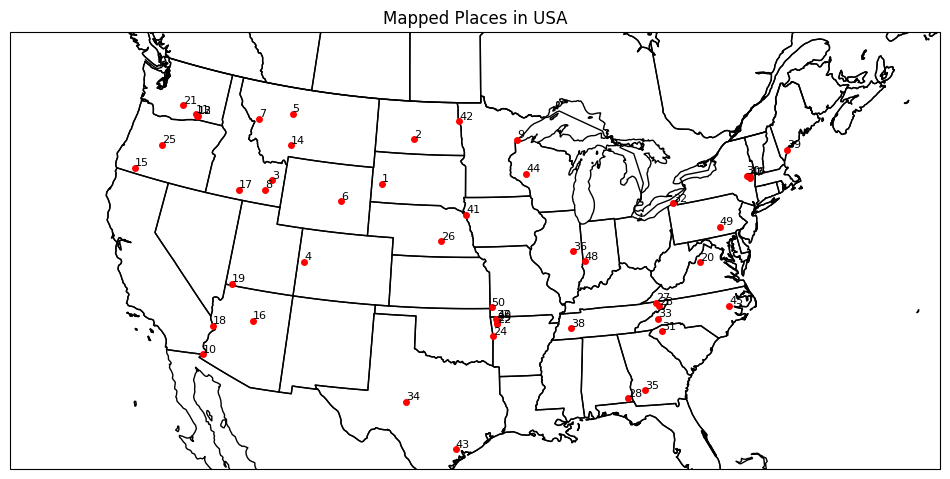

In [20]:
# Plot a map of results
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.Geodetic())

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Plot and annotate each point with its index
for idx, row in isolated.iterrows():
    ax.plot(
        row['Longitude'], row['Latitude'],
        marker='o', color='red', markersize=4,
        transform=ccrs.Geodetic()
    )
    ax.text(
        row['Longitude'], row['Latitude'], str(idx+1),
        transform=ccrs.Geodetic(),
        fontsize=8, ha='left', va='bottom'
    )

plt.title("Mapped Places in USA")
plt.show()
